In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.generalTools import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [2]:
xr.set_options(display_style='text') 

# Functions, data

In [3]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [4]:
def add_text(ax):
    ax.text(0.1, 0.1,'EAST (upstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")
    ax.text(0.9, 0.1,'WEST (downstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")

In [5]:
%%time
hrchannel10         = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/"         )
hrchannel10_wk      = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/"  )
hrchannel10_wk_aqua = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/")

CPU times: user 12.3 s, sys: 4.9 s, total: 17.2 s
Wall time: 15.8 s


In [6]:
%%time
hrchannel10_p         = extract_wrfpro("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/"         )
hrchannel10_wk_p      = extract_wrfpro("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/"  )
hrchannel10_wk_aqua_p = extract_wrfpro("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/")

CPU times: user 1.95 s, sys: 656 ms, total: 2.6 s
Wall time: 3.7 s


In [7]:
hrhgt = hrchannel10.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3
def plothrsection(figsize=(15,4)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.set_xlabel("distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot(hrdist,hrhgt,color='k')
    return ax,ax.twinx()

In [8]:
hrchannel10_precip = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc")
hrchannel10_aqua_precip = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.precip.days0-100.nc")

hrchannel10_wk_precip = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/diags/wrf.precip.days0-200.nc")
hrchannel10_302_precip = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.precip.days0-100.nc")
hrchannel10_wk_aqua_precip = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/diags/wrf.precip.days0-100.nc")


hrchannel10_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d
hrchannel10_wk_capecin =xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d
hrchannel10_302_capecin =xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d
hrchannel10_wk_aqua_capecin =xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d




In [9]:

hrchannel10_aqua_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

# Compute diags

In [22]:
from wrf import cape_2d
import wrf
from netCDF4 import Dataset

def compute_individual_cape(file):
    return wrf.getvar(Dataset(file), "cape_2d", timeidx=wrf.ALL_TIMES)


In [11]:
%%time
#Takes 1 hour
path="/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/"
if not os.path.isdir(path+'diags'):
    print('creating diags directory')
    os.mkdir(path+'diags')
for file in sorted(glob.glob(path+"wrfout*")):
    print(file)
    c = compute_individual_cape(file)
    del(c.attrs['projection'])
    c.to_netcdf(path+'diags/wrf.cape.'+file[-19:]+'.nc')
    

/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/wrfout_d01_1970-01-01_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/wrfout_d01_1970-01-11_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/wrfout_d01_1970-01-21_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/wrfout_d01_1970-01-31_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/wrfout_d01_1970-02-10_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/wrfout_d01_1970-02-20_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/wrfout_d01_1970-03-02_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/wrfout_d01_1970-03-12_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.

In [12]:
%%time
path="/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/"
hrchannel10_wk_aqua_w = hrchannel10_wk_aqua.W.isel(Time=slice(200,401)).mean(["Time","south_north"])
hrchannel10_wk_aqua_w.to_netcdf(path+"diags/wrf.W.days50-100.nc")


CPU times: user 8.54 s, sys: 17.4 s, total: 26 s
Wall time: 24.8 s


In [13]:
%%time
path="/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/"
hrchannel10_wk_aqua_precip = 4*(hrchannel10_wk_aqua.RAINC+hrchannel10_wk_aqua.RAINNC).diff('Time').persist()
hrchannel10_wk_aqua_precip.to_netcdf(path+"diags/wrf.precip.days0-100.nc")


CPU times: user 1.21 s, sys: 44.2 s, total: 45.4 s
Wall time: 1min 37s


In [14]:
path="/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/"
%time wmean  = hrchannel10_wk_aqua_p.W_PL.isel(Time=slice(1200,2401)).mean(['Time','south_north']).persist()
%time rhomean= hrchannel10_wk_aqua_p.RHO_PL.isel(Time=slice(1200,2401)).mean(['Time','south_north']).persist()
%time tmean  = hrchannel10_wk_aqua_p.T_PL.isel(Time=slice(1200,2401)).mean(['Time','south_north']).persist()
%time qmean  = hrchannel10_wk_aqua_p.Q_PL.isel(Time=slice(1200,2401)).mean(['Time','south_north']).persist()

wmean.to_netcdf(path+'diags/wrf.W_PL.days50-100.nc')
rhomean.to_netcdf(path+'diags/wrf.RHO_PL.days50-100.nc')
tmean.to_netcdf(path+'diags/wrf.T_PL.days50-100.nc')
qmean.to_netcdf(path+'diags/wrf.Q_PL.days50-100.nc')

CPU times: user 45 s, sys: 3min 37s, total: 4min 22s
Wall time: 3min 18s
CPU times: user 41.6 s, sys: 3min 52s, total: 4min 34s
Wall time: 3min 37s
CPU times: user 41.2 s, sys: 3min 40s, total: 4min 21s
Wall time: 3min 23s
CPU times: user 44.5 s, sys: 3min 49s, total: 4min 33s
Wall time: 3min 25s


In [10]:
%%time
path="/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/"
hrchannel10_wk_w = hrchannel10_wk.W.isel(Time=slice(200,801)).mean(["Time","south_north"])
hrchannel10_wk_w.to_netcdf(path+"diags/wrf.W.days50-200.nc")


CPU times: user 26.2 s, sys: 1min 42s, total: 2min 8s
Wall time: 1min 32s


In [11]:
%%time
path="/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/"
hrchannel10_wk_precip = 4*(hrchannel10_wk.RAINC+hrchannel10_wk.RAINNC).diff('Time').persist()
hrchannel10_wk_precip.to_netcdf(path+"diags/wrf.precip.days0-200.nc")


CPU times: user 2.52 s, sys: 2min 40s, total: 2min 43s
Wall time: 4min 38s


In [31]:
path="/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/"
%time wmean  = hrchannel10_wk_p.W_PL.isel(Time=slice(1200,4801)).mean(['Time','south_north']).persist()
%time rhomean= hrchannel10_wk_p.RHO_PL.isel(Time=slice(1200,4801)).mean(['Time','south_north']).persist()
%time tmean  = hrchannel10_wk_p.T_PL.isel(Time=slice(1200,4801)).mean(['Time','south_north']).persist()
%time qmean  = hrchannel10_wk_p.Q_PL.isel(Time=slice(1200,4801)).mean(['Time','south_north']).persist()

wmean.to_netcdf(path+'diags/wrf.W_PL.days50-200.nc')
rhomean.to_netcdf(path+'diags/wrf.RHO_PL.days50-200.nc')
tmean.to_netcdf(path+'diags/wrf.T_PL.days50-200.nc')
qmean.to_netcdf(path+'diags/wrf.Q_PL.days50-200.nc')

CPU times: user 2min 2s, sys: 10min 43s, total: 12min 45s
Wall time: 9min 25s
CPU times: user 2min 7s, sys: 11min 37s, total: 13min 44s
Wall time: 9min 54s
CPU times: user 2min 5s, sys: 12min 32s, total: 14min 38s
Wall time: 10min 28s


In [23]:
%%time
#Takes 1 hour
path="/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/"
if not os.path.isdir(path+'diags'):
    print('creating diags directory')
    os.mkdir(path+'diags')
for file in sorted(glob.glob(path+"wrfout*"))[2:]:
    print(file)
    c = compute_individual_cape(file)
    del(c.attrs['projection'])
    c.to_netcdf(path+'diags/wrf.cape.'+file[-19:]+'.nc')
    

/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/wrfout_d01_1970-01-21_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/wrfout_d01_1970-01-31_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/wrfout_d01_1970-02-10_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/wrfout_d01_1970-02-20_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/wrfout_d01_1970-03-02_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/wrfout_d01_1970-03-12_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/wrfout_d01_1970-03-22_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/wrfout_d01_1970-04-01_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/wrfout_d01_197

# Lon-lev cross sections

## W

In [9]:
def open_wplot(sim,path):
    w=xr.open_dataarray(path)
    return w.assign_coords({'distance_from_mtn':(1635-w.west_east)*3,'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()

hrchannel10_wplot=open_wplot(hrchannel10,"/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.days50-200.nc")
hrchannel10_wk_wplot=open_wplot(hrchannel10_wk,"/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/diags/wrf.W.days50-200.nc")
hrchannel10_302_wplot=open_wplot(hrchannel10_wk,"/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.W.days50-200.nc")
hrchannel10_wk_aqua_wplot=open_wplot(hrchannel10_wk_aqua,"/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/diags/wrf.W.days50-100.nc")


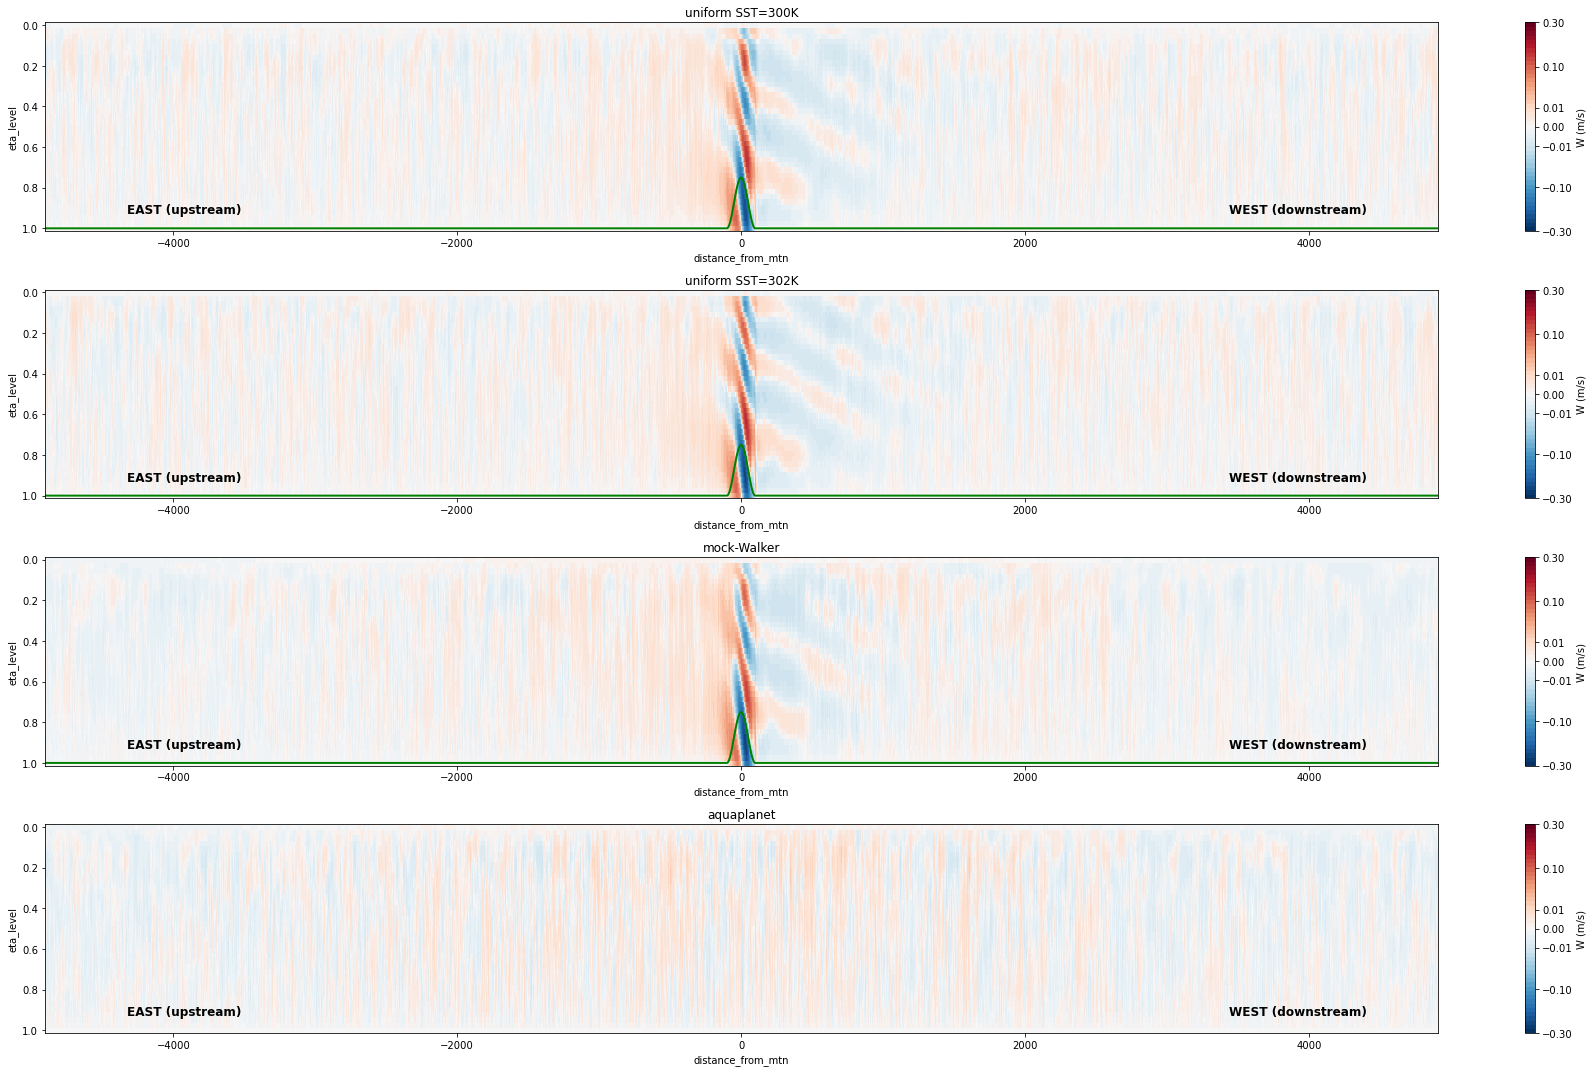

In [11]:
def f(x):
    return np.sign(x)*x**2
def plot_w(w,ax,add_mtn=1):
    w.plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=f(np.linspace(-(0.3)**(1/2),0.3**(1/2),50)),cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3], 'label':'W (m/s)'})
    add_text(ax)
    if add_mtn:
        ax.plot(w.distance_from_mtn, 1-hrhgt/4000,color='g',linewidth=2)
    
fig,ax=plt.subplots(4,1,figsize=(25,15))
plot_w(hrchannel10_wplot        ,ax[0])
plot_w(hrchannel10_302_wplot    ,ax[1])
plot_w(hrchannel10_wk_wplot     ,ax[2])
plot_w(hrchannel10_wk_aqua_wplot,ax[3],0)

ax[0].set_title("uniform SST=300K")
ax[1].set_title("uniform SST=302K")
ax[2].set_title("mock-Walker")
ax[3].set_title("aquaplanet")

fig.tight_layout()


Text(0.5, 1.0, 'mock-Walker minus uniform SST=302K')

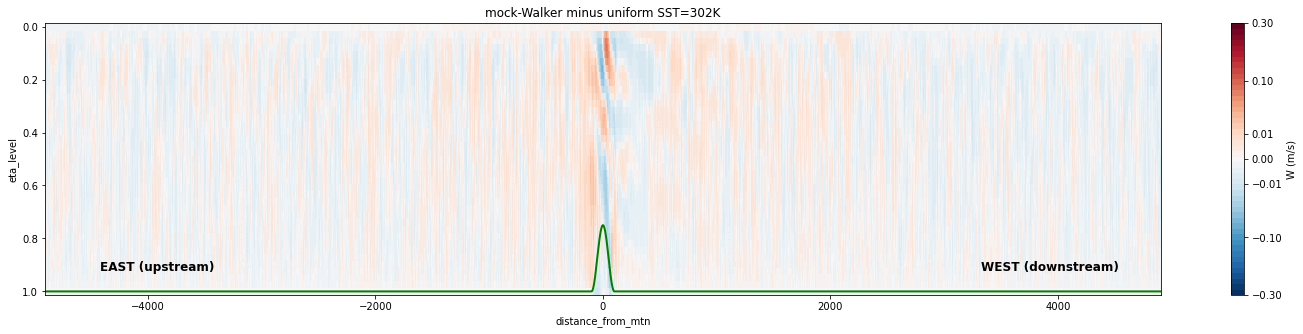

In [12]:
fig,ax=plt.subplots(1,1,figsize=(25,5))
plot_w(hrchannel10_wk_wplot-hrchannel10_302_wplot,ax)
ax.set_title("mock-Walker minus uniform SST=302K")



Text(0.5, 1.0, 'mock-Walker minus uniform SST=302K')

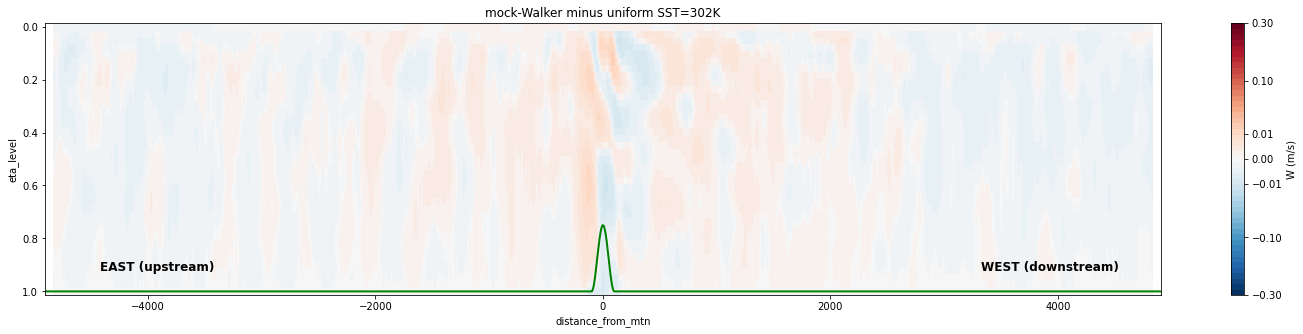

In [13]:
fig,ax=plt.subplots(1,1,figsize=(25,5))
plot_w((hrchannel10_wk_wplot-hrchannel10_302_wplot).rolling(distance_from_mtn=51, center=True).mean(),ax)
ax.set_title("mock-Walker minus uniform SST=302K")



## Mid-tropospheric temperature profiles

In [57]:
tmean_300 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
tmean_300 = tmean_300.where(tmean_300 >100.)[1:-4]  
tmean_302 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.T_PL.days50-100.nc')
tmean_302 = tmean_302.where(tmean_302 >100.)[1:-4]
tmean_wk_aqua = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.walker.3km/diags/wrf.T_PL.days50-100.nc')
tmean_wk_aqua = tmean_wk_aqua.where(tmean_wk_aqua >100.)  
tmean_wk = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/diags/wrf.T_PL.days50-200.nc')
tmean_wk = tmean_wk.where(tmean_wk >100.)  

(-100.0, 4000.0)

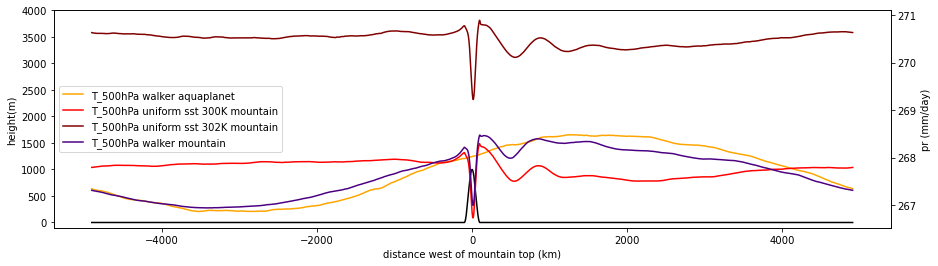

In [59]:
ax,ax2=plothrsection()
ax2.set_ylabel("pr (mm/day)")

ax2.plot(hrdist,tmean_wk_aqua.isel(num_press_levels_stag=14),color='orange',label='T_500hPa walker aquaplanet')
ax2.plot(hrdist,tmean_300.isel(num_press_levels_stag=14),color='r'     ,label='T_500hPa uniform sst 300K mountain')
ax2.plot(hrdist,tmean_302.isel(num_press_levels_stag=14),color='maroon',label='T_500hPa uniform sst 302K mountain')
ax2.plot(hrdist,tmean_wk.isel(num_press_levels_stag=14),color='indigo',label='T_500hPa walker mountain')


ax2.legend()
ax.set_ylim(-100,4000)

## Precip,Cape

(-100.0, 3000.0)

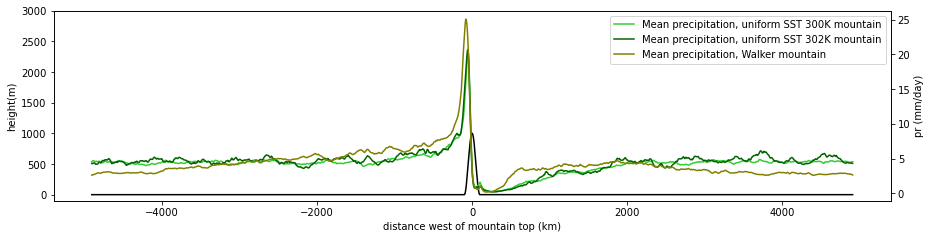

In [30]:
ax,ax2=plothrsection(figsize=(15,3.5))
ax2.set_ylabel("pr (mm/day)")

#ax2.plot(hrdist,hrchannel10_wk_aqua_precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='lime',label='Mean precipitation, Walker aquaplanet')
ax2.plot(hrdist,hrchannel10_precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='limegreen',    label='Mean precipitation, uniform SST 300K mountain')
ax2.plot(hrdist,hrchannel10_302_precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='darkgreen',label='Mean precipitation, uniform SST 302K mountain')
ax2.plot(hrdist,hrchannel10_wk_precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='olive',     label='Mean precipitation, Walker mountain')

ax2.legend()
ax.set_ylim(-100,3000)

(-100.0, 2500.0)

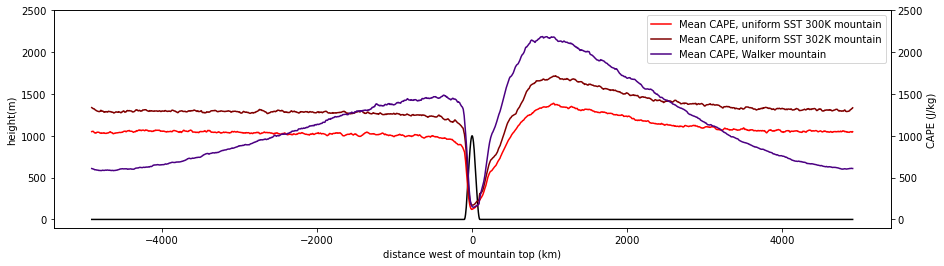

In [31]:
ax,ax2=plothrsection()
ax2.set_ylabel("CAPE (J/kg)")

#ax2.plot(hrdist,hrchannel10_wk_aqua_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time']),color='orange',label='CAPE walker aquaplanet')
ax2.plot(hrdist,hrchannel10_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])        ,color='r'     ,label='Mean CAPE, uniform SST 300K mountain')
ax2.plot(hrdist,hrchannel10_302_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])    ,color='maroon',label='Mean CAPE, uniform SST 302K mountain')
ax2.plot(hrdist,hrchannel10_wk_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])     ,color='indigo',label='Mean CAPE, Walker mountain')

ax2.legend()
ax.set_ylim(-100,2500)
ax2.set_ylim(-100,2500)

(0.0, 200000.0)

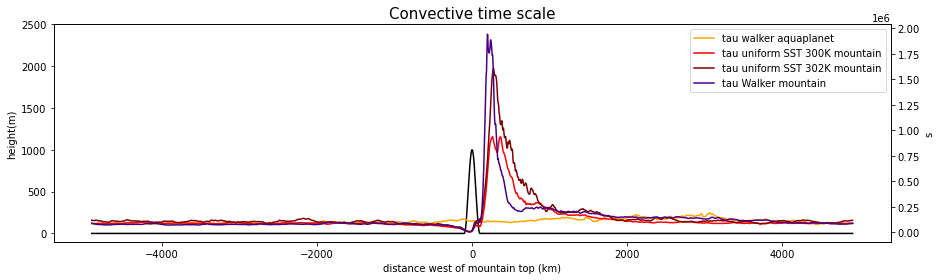

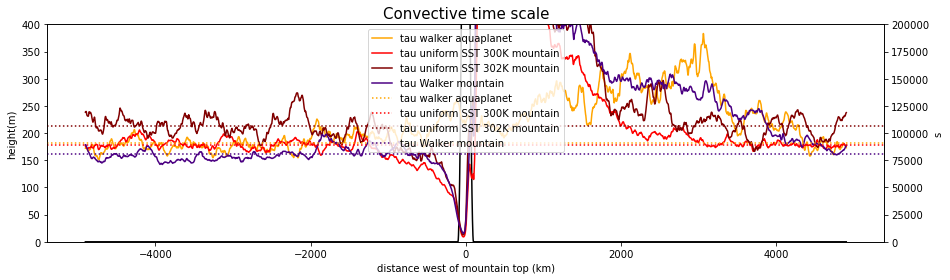

In [13]:
factor = 1/(2.26e6/86400/10000)
ax,ax2=plothrsection()

ax2.plot(hrdist,factor*hrchannel10_wk_aqua_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])/hrchannel10_wk_aqua_precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='orange',label='tau walker aquaplanet')
ax2.plot(hrdist,factor*hrchannel10_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])        /hrchannel10_precip.isel(Time=slice(200,801)).mean(['south_north','Time'])        ,color='r'     ,label='tau uniform SST 300K mountain')
ax2.plot(hrdist,factor*hrchannel10_302_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])    /hrchannel10_302_precip.isel(Time=slice(200,801)).mean(['south_north','Time'])    ,color='maroon',label='tau uniform SST 302K mountain')
ax2.plot(hrdist,factor*hrchannel10_wk_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])     /hrchannel10_wk_precip.isel(Time=slice(200,801)).mean(['south_north','Time'])     ,color='indigo',label='tau Walker mountain')

ax2.set_title("Convective time scale", fontsize=15)
ax2.set_ylabel("s")
ax2.legend()
ax.set_ylim(-100,2500)

ax,ax2=plothrsection()
ax2.plot(hrdist,factor*hrchannel10_wk_aqua_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])/hrchannel10_wk_aqua_precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='orange',label='tau walker aquaplanet')
ax2.plot(hrdist,factor*hrchannel10_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])        /hrchannel10_precip.isel(Time=slice(200,801)).mean(['south_north','Time'])        ,color='r'     ,label='tau uniform SST 300K mountain')
ax2.plot(hrdist,factor*hrchannel10_302_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])    /hrchannel10_302_precip.isel(Time=slice(200,801)).mean(['south_north','Time'])    ,color='maroon',label='tau uniform SST 302K mountain')
ax2.plot(hrdist,factor*hrchannel10_wk_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])     /hrchannel10_wk_precip.isel(Time=slice(200,801)).mean(['south_north','Time'])     ,color='indigo',label='tau Walker mountain')
ax2.axhline((factor*hrchannel10_wk_aqua_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])/hrchannel10_wk_aqua_precip.isel(Time=slice(200,801)).mean(['south_north','Time'])).isel(west_east=slice(2000,3000)).mean(),color='orange',linestyle=':',label='tau walker aquaplanet')
ax2.axhline((factor*hrchannel10_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])        /hrchannel10_precip.isel(Time=slice(200,801)).mean(['south_north','Time'])        ).isel(west_east=slice(2000,3000)).mean(),color='r'     ,linestyle=':',label='tau uniform SST 300K mountain')
ax2.axhline((factor*hrchannel10_302_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])    /hrchannel10_302_precip.isel(Time=slice(200,801)).mean(['south_north','Time'])    ).isel(west_east=slice(2000,3000)).mean(),color='maroon',linestyle=':',label='tau uniform SST 302K mountain')
ax2.axhline((factor*hrchannel10_wk_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])     /hrchannel10_wk_precip.isel(Time=slice(200,801)).mean(['south_north','Time'])     ).isel(west_east=slice(2000,3000)).mean(),color='indigo',linestyle=':',label='tau Walker mountain')

ax2.set_title("Convective time scale", fontsize=15)
ax2.set_ylabel("s")
ax2.legend()
ax.set_ylim(0.,400)
ax2.set_ylim(0.,2e5)

4.2192564
4.227634


(-4000.0, 4000.0)

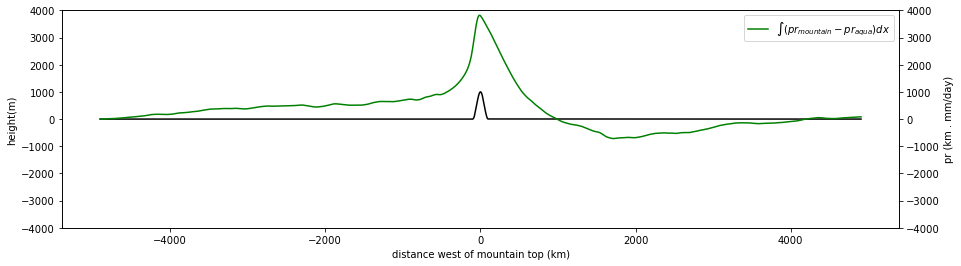

In [31]:
ax,ax2=plothrsection()
ax2.set_ylabel("pr (km . mm/day)")

aq_wk = np.array(hrchannel10_wk_aqua_precip.isel(Time=slice(200,801)).mean(['south_north','Time']))[::-1]
mt_wk = np.array(hrchannel10_wk_precip.isel(Time=slice(200,801)).mean(['south_north','Time']))[::-1]

print(aq_wk.mean())
print(mt_wk.mean())

ax2.plot(hrdist[::-1],3*np.cumsum(mt_wk-aq_wk),color='g',label=r'$\int (pr_{mountain} - pr_{aqua}) dx$')

ax2.legend()
ax.set_ylim(-4000,4000)
ax2.set_ylim(-4000,4000)

4.269319
4.2543764


(-4000.0, 4000.0)

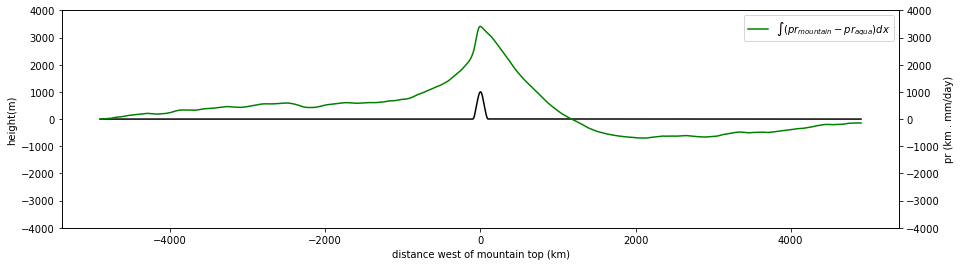

In [13]:
ax,ax2=plothrsection()
ax2.set_ylabel("pr (km . mm/day)")

aq_wk = np.array(hrchannel10_aqua_precip.isel(Time=slice(200,801)).mean(['south_north','Time']))[::-1]
mt_wk = np.array(hrchannel10_precip.isel(Time=slice(200,801)).mean(['south_north','Time']))[::-1]

print(aq_wk.mean())
print(mt_wk.mean())

ax2.plot(hrdist[::-1],3*np.cumsum(mt_wk-aq_wk),color='g',label=r'$\int (pr_{mountain} - pr_{aqua}) dx$')

ax2.legend()
ax.set_ylim(-4000,4000)
ax2.set_ylim(-4000,4000)

(-100.0, 3000.0)

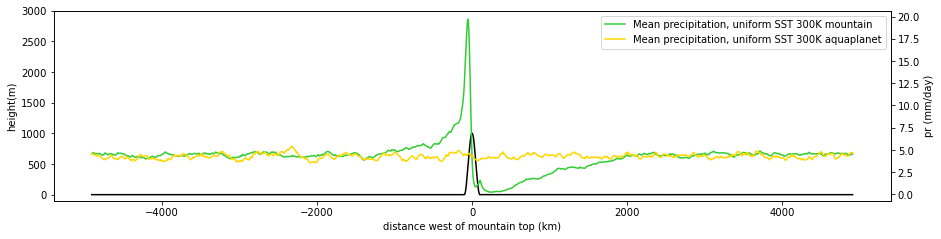

In [14]:
ax,ax2=plothrsection(figsize=(15,3.5))
ax2.set_ylabel("pr (mm/day)")
ax2.plot(hrdist,hrchannel10_precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='limegreen',    label='Mean precipitation, uniform SST 300K mountain')
ax2.plot(hrdist,hrchannel10_aqua_precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='gold',label='Mean precipitation, uniform SST 300K aquaplanet')

ax2.legend()
ax.set_ylim(-100,3000)

(-100.0, 2500.0)

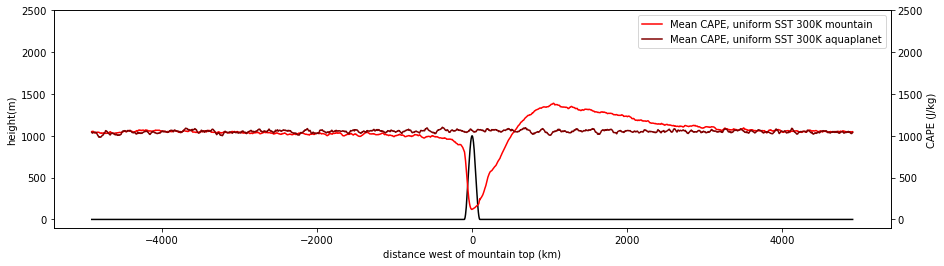

In [17]:
ax,ax2=plothrsection()
ax2.set_ylabel("CAPE (J/kg)")

ax2.plot(hrdist,hrchannel10_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])        ,color='r'     ,label='Mean CAPE, uniform SST 300K mountain')
ax2.plot(hrdist,hrchannel10_aqua_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])    ,color='maroon',label='Mean CAPE, uniform SST 300K aquaplanet')

ax2.legend()
ax.set_ylim(-100,2500)
ax2.set_ylim(-100,2500)

## Fractional changes

In [10]:
def frac_change(var1,var2,a1,a2):
    assert a2 < a1
    b1 = 1635-a1//3
    b2 = 1635-a2//3 
    return (100*(-1+var2.isel(Time=slice(200,801),west_east=slice(b1,b2)).mean()/
             var1.isel(Time=slice(200,801),west_east=slice(b1,b2)).mean()
           ))

def frac_change2(var1,var2,a1,a2,a3,a4):
    assert a2 < a1
    b1 = 1635-a1//3
    b2 = 1635-a2//3 
    b3 = 1635-a3//3
    b4 = 1635-a4//3 
    return (100*(-1+var2.isel(Time=slice(200,801),west_east=slice(b1,b2)).mean()/
             var1.isel(Time=slice(200,801),west_east=slice(b3,b4)).mean()
           ))

def frac_change_max(var1,var2):
    return (100*(-1+var2.isel(Time=slice(200,801)).mean(['Time','south_north']).max()/
             var1.isel(Time=slice(200,801)).mean(['Time','south_north']).max()
           ))

def frac_change_max2(var1,var2,a3,a4):
    b3 = 1635-a3//3
    b4 = 1635-a4//3 
    return (100*(-1+var2.isel(Time=slice(200,801)).mean(['Time','south_north']).max()/
             var1.isel(Time=slice(200,801),west_east=slice(b3,b4)).mean()
           ))

In [12]:
# Precip
print("Fractional change in whole domain :")
print("300K to 302K   : %.1f%%"%frac_change(hrchannel10_precip,hrchannel10_302_precip,4906,-4906))
print("300K to walker   : %.1f%%"%frac_change(hrchannel10_precip,hrchannel10_wk_precip,4906,-4906))
print("aquaplanet walker to mountain walker   : %.1f%%"%frac_change(hrchannel10_wk_aqua_precip,hrchannel10_wk_precip,4906,-4906))
print("aquaplanet to mountain   : %.1f%%"%frac_change(hrchannel10_aqua_precip,hrchannel10_precip,4906,-4906))


print("Fractional changes in 0-500km upstream region :")
print("300K to 302K   : %.1f%%"%frac_change(hrchannel10_precip,hrchannel10_302_precip,0,-500))
print("302K to walker : %.1f%%"%frac_change(hrchannel10_302_precip,hrchannel10_wk_precip,0,-500))

print("Fractional changes in 0-100km upstream region :")
print("300K to 302K   : %.1f%%"%frac_change(hrchannel10_precip,hrchannel10_302_precip,0,-100))
print("302K to walker : %.1f%%"%frac_change(hrchannel10_302_precip,hrchannel10_wk_precip,0,-100))
print("aquaplanet 302 to 302K : %.1f%%"%frac_change2(hrchannel10_302_precip,hrchannel10_302_precip,0,-100,4906,-4906))
print("aquplanet wk to walker : %.1f%%"%frac_change2(hrchannel10_wk_aqua_precip,hrchannel10_wk_precip,0,-100,4906,-4906))

print("Fractional changes in max. precip :")
print("300K to 302K   : %.1f%%"%frac_change_max(hrchannel10_precip,hrchannel10_302_precip))
print("302K to walker : %.1f%%"%frac_change_max(hrchannel10_302_precip,hrchannel10_wk_precip))
print("aquaplanet 302 to 302K : %.1f%%"%frac_change_max2(hrchannel10_302_precip,hrchannel10_302_precip,4906,-4906))
print("aquplanet wk to walker : %.1f%%"%frac_change_max2(hrchannel10_wk_aqua_precip,hrchannel10_wk_precip,4906,-4906))


Fractional change in whole domain :
300K to 302K   : 4.8%
300K to walker   : -0.6%
aquaplanet walker to mountain walker   : 0.2%
aquaplanet to mountain   : -0.3%
Fractional changes in 0-500km upstream region :
300K to 302K   : 2.3%
302K to walker : 28.8%
Fractional changes in 0-100km upstream region :
300K to 302K   : 4.1%
302K to walker : 16.9%
aquaplanet 302 to 302K : 238.1%
aquplanet wk to walker : 317.9%
Fractional changes in max. precip :
300K to 302K   : 5.0%
302K to walker : 21.3%
aquaplanet 302 to 302K : 363.6%
aquplanet wk to walker : 494.7%


# Soundings

## W soundings

In [17]:
ppl = hrchannel10_wk_p.P_PL[0]
hrchannel10_wpl     = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.days50-200.nc")[1:-4]
hrchannel10_wk_wpl  = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/diags/wrf.W_PL.days50-200.nc")
hrchannel10_302_wpl = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.W_PL.days50-200.nc")[1:-4]

hrchannel10_wpl     = hrchannel10_wpl.where(hrchannel10_wpl    >-1.)
hrchannel10_wk_wpl  = hrchannel10_wk_wpl.where(hrchannel10_wk_wpl >-1.)
hrchannel10_302_wpl = hrchannel10_302_wpl.where(hrchannel10_302_wpl>-1.)

In [18]:
hrchannel10_rhopl     = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO_PL.days50-200.nc")[1:-4]
hrchannel10_wk_rhopl  = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.walker.3km/diags/wrf.RHO_PL.days50-200.nc")
hrchannel10_302_rhopl = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.RHO_PL.days50-100.nc")[1:-4]

hrchannel10_rhopl     = hrchannel10_rhopl.where(hrchannel10_rhopl        >0.)
hrchannel10_wk_rhopl  = hrchannel10_wk_rhopl.where(hrchannel10_wk_rhopl  >0.)
hrchannel10_302_rhopl = hrchannel10_302_rhopl.where(hrchannel10_302_rhopl>0.)

In [19]:
hrchannel10_omegapl     = -9.81*hrchannel10_rhopl    *hrchannel10_wpl    
hrchannel10_wk_omegapl  = -9.81*hrchannel10_wk_rhopl *hrchannel10_wk_wpl 
hrchannel10_302_omegapl = -9.81*hrchannel10_302_rhopl*hrchannel10_302_wpl

In [21]:
def plot_vprofile(p,var,a1,a2,ax,clr,lbl):
    assert a2 < a1
    b1 = 1635-a1//3
    b2 = 1635-a2//3 
    ax.plot(var.sel(west_east=slice(b1,b2)).mean('west_east'),p,label=lbl,color=clr)

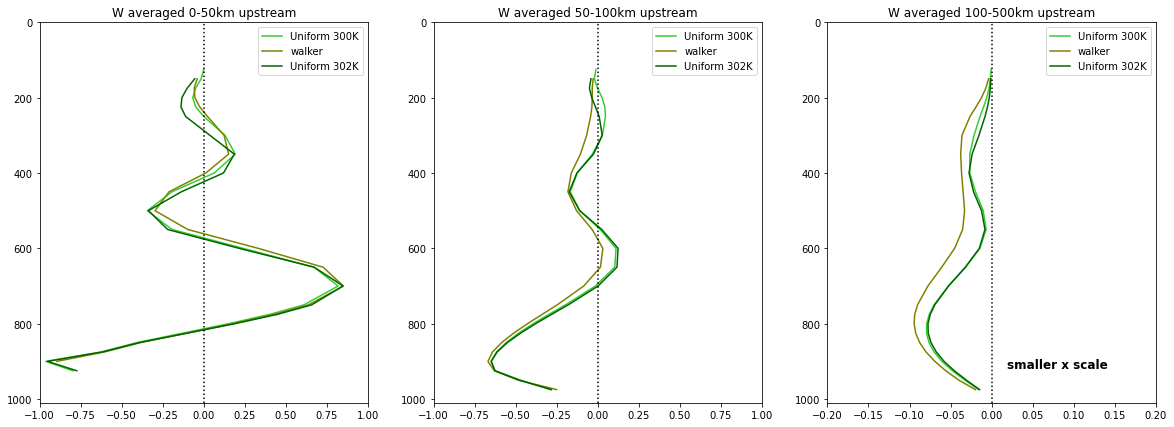

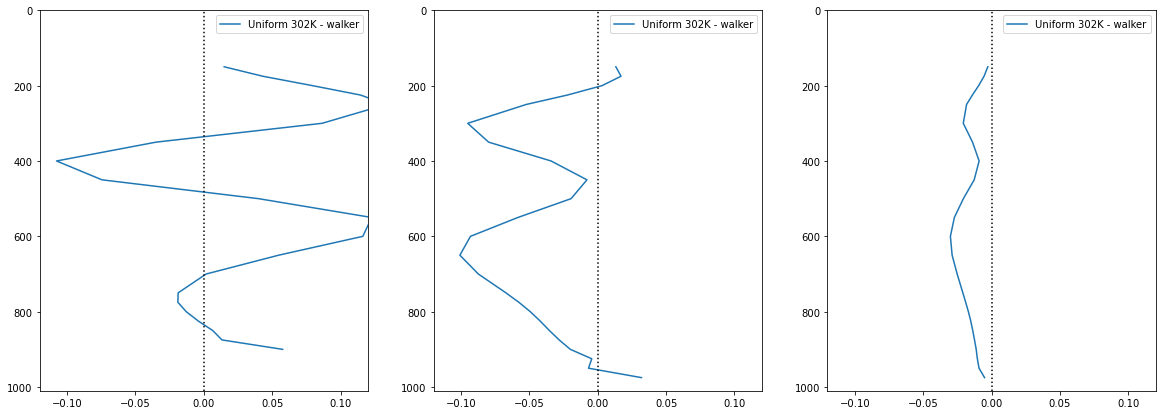

In [28]:
_,ax=plt.subplots(1,3,figsize=(20,7))

plot_vprofile(ppl/100,hrchannel10_omegapl    ,0,-50,ax[0],'limegreen',"Uniform 300K")
plot_vprofile(ppl/100,hrchannel10_wk_omegapl ,0,-50,ax[0],'olive'    ,"walker")
plot_vprofile(ppl/100,hrchannel10_302_omegapl,0,-50,ax[0],'darkgreen',"Uniform 302K")


plot_vprofile(ppl/100,hrchannel10_omegapl    ,-50,-100,ax[1],'limegreen',"Uniform 300K")
plot_vprofile(ppl/100,hrchannel10_wk_omegapl ,-50,-100,ax[1],'olive'    ,"walker")
plot_vprofile(ppl/100,hrchannel10_302_omegapl,-50,-100,ax[1],'darkgreen',"Uniform 302K")

plot_vprofile(ppl/100,hrchannel10_omegapl    ,-100,-500,ax[2],'limegreen',"Uniform 300K")
plot_vprofile(ppl/100,hrchannel10_wk_omegapl ,-100,-500,ax[2],'olive'    ,"walker")
plot_vprofile(ppl/100,hrchannel10_302_omegapl,-100,-500,ax[2],'darkgreen',"Uniform 302K")



ax[0].set_title("W averaged 0-50km upstream")
ax[1].set_title("W averaged 50-100km upstream")
ax[2].set_title("W averaged 100-500km upstream")
for a in ax:
    a.set_ylim(1010,0)
    a.legend()
    a.axvline(0,linestyle='dotted',color='k')
    a.set_xlim(-1.,1.)
ax[2].set_xlim(-.2,.2)
ax[2].text(0.7, 0.1,'smaller x scale', ha='center', va='center', transform=ax[2].transAxes, fontsize=12,fontweight="heavy")

_,ax=plt.subplots(1,3,figsize=(20,7))

plot_vprofile(ppl/100,hrchannel10_wk_omegapl-hrchannel10_302_omegapl,0,-50,ax[0],None,"Uniform 302K - walker")
plot_vprofile(ppl/100,hrchannel10_wk_omegapl-hrchannel10_302_omegapl,-50,-100,ax[1],None,"Uniform 302K - walker")
plot_vprofile(ppl/100,hrchannel10_wk_omegapl-hrchannel10_302_omegapl,-100,-500,ax[2],None,"Uniform 302K - walker")
for a in ax:
    a.set_ylim(1010,0)
    a.legend()
    a.axvline(0,linestyle='dotted',color='k')
    a.set_xlim(-.12,.12)

## Skew-Ts

In [58]:
plevs=np.array([100000,97500,95000,92500,90000,87500,85000,82500,80000,77500,75000,70000,65000,60000,55000,50000,45000,40000,35000,30000,25000,22500,20000,17500,15000,12500,10000,7000,5000,1000])/100


In [59]:
qmean_300 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
tmean_300 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
qmean_300 = qmean_300.where(qmean_300 >0.)  
tmean_300 = tmean_300.where(tmean_300 >100.)  

In [60]:
qmean_302 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.Q_PL.days50-100.nc')
tmean_302 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.T_PL.days50-100.nc')
qmean_302 = qmean_302.where(qmean_302 >0.)  
tmean_302 = tmean_302.where(tmean_302 >100.)  

In [ ]:
def plot_skewt(T,q,plevs,skew,color,lbl):
    P = plevs* units.hPa
    i=0
    Tups = units.degK*np.array(T)
    qups = np.array(q)

    #P=P[::-1]
    #Tups=Tups[::-1]
    #qups=qups[::-1]

    skew.plot(P, Tups,color=color ,label=lbl)
    
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)
    #Calculate full parcel profile and add to plot as black line
    
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)
    profups = mpcalc.parcel_profile(P, Tups[0], Tdups[0]).to('degC')
    skew.plot(P, profups, color=color, linewidth=2)
    skew.shade_cape(P, Tups, profups,color=color)

    skew.plot(P, Tdups,color=color ,label=lbl)
    
fig = plt.figure(figsize=(10,7))
skew = SkewT(fig, rotation=45)

s,lbl=(-4900,-1000),"300K"
plot_skewt(tmean_300.isel(west_east=slice(1635-s[1]//3,1635-s[0]//3)).mean("west_east")[1:-4],qmean_300.isel(west_east=slice(1635-s[1]//3,1635-s[0]//3)).mean("west_east")[1:-4],plevs[1:-4],skew,"orange",lbl)
s,lbl=(-4900,-1000),"302K"
plot_skewt(tmean_302.isel(west_east=slice(1635-s[1]//3,1635-s[0]//3)).mean("west_east")[1:-4],qmean_302.isel(west_east=slice(1635-s[1]//3,1635-s[0]//3)).mean("west_east")[1:-4],plevs[1:-4],skew,"red",lbl)


skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 50)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
plt.legend()
#fig.suptitle(title + " || upstream CAPE = %.1f J/kg, downstream = %.1f J/kg"%(mpcalc.cape_cin(P, Tups, Tdups,profups)[0]/units("J/kg"),mpcalc.cape_cin(P, Tdws, Tddws,profdws)[0]/units("J/kg")),fontsize=20)


# Aquaplanet analysis

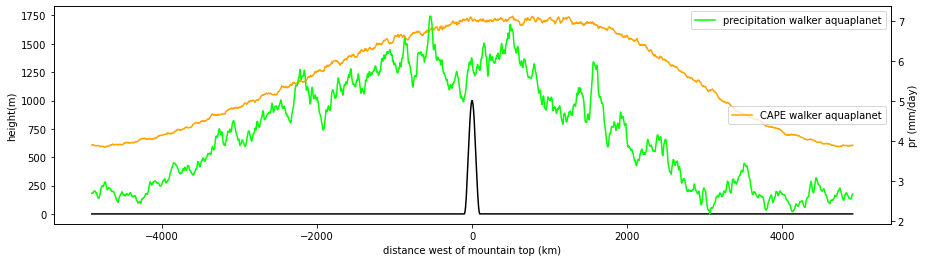

In [34]:
ax,ax2=plothrsection()
ax2.set_ylabel("pr (mm/day)")

ax2.plot(hrdist,hrchannel10_wk_aqua_precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='lime',label='precipitation walker aquaplanet')
ax.plot(hrdist,hrchannel10_wk_aqua_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time']),color='orange',label='CAPE walker aquaplanet')

ax.legend(loc="center right")
ax2.legend()


In [41]:
def rad_cooling(sim):
    mSWUPT = (sim.ACSWUPT.isel(Time = -1)-sim.ACSWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNT = (sim.ACSWDNT.isel(Time = -1)-sim.ACSWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWUPB = (sim.ACSWUPB.isel(Time = -1)-sim.ACSWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNB = (sim.ACSWDNB.isel(Time = -1)-sim.ACSWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPT = (sim.ACLWUPT.isel(Time = -1)-sim.ACLWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNT = (sim.ACLWDNT.isel(Time = -1)-sim.ACLWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPB = (sim.ACLWUPB.isel(Time = -1)-sim.ACLWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNB = (sim.ACLWDNB.isel(Time = -1)-sim.ACLWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    return mSWUPT-mSWDNT-mSWUPB+mSWDNB+mLWUPT-mLWDNT-mLWUPB+mLWDNB
hrchannel10_wk_aqua_R = rad_cooling(hrchannel10_wk_aqua.isel(Time=slice(200,801))).mean(['south_north']).persist()

In [85]:
hfx=hrchannel10_wk_aqua.HFX.isel(Time=slice(200,800)).mean(['south_north','Time']).persist()
lfx=2.26e6*hrchannel10_wk_aqua.QFX.isel(Time=slice(200,800)).mean(['south_north','Time']).persist()

(0.0, 4000.0)

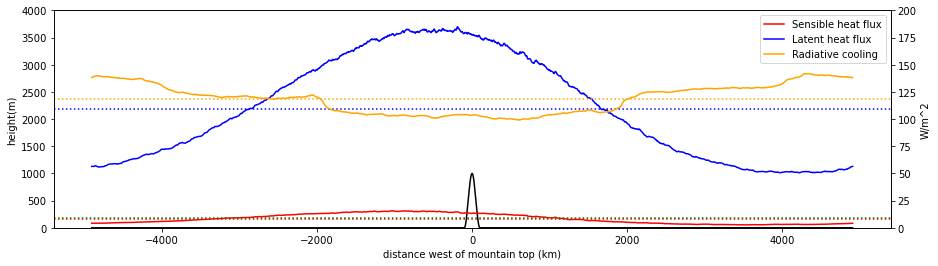

In [86]:
ax,ax2=plothrsection()
ax2.set_ylabel("W/m^2")

ax2.plot(hrdist,hfx,color='r',label='Sensible heat flux')
ax2.axhline(hfx.mean(),color='r',linestyle=':')

ax2.plot(hrdist,lfx,color='blue',label='Latent heat flux')
ax2.axhline(lfx.mean(),color='blue',linestyle=':')

ax2.plot(hrdist,hrchannel10_wk_aqua_R,color='orange',label='Radiative cooling')
ax2.axhline(hrchannel10_wk_aqua_R.mean(),color='orange',linestyle=':')

ax2.axhline(hrchannel10_wk_aqua_R.mean()-lfx.mean(),color='green',linestyle=':')



ax2.legend()
ax2.set_ylim(0,200)
ax.set_ylim(0,4000)


In [73]:
from scipy.integrate import cumtrapz
def cape_analytical_Lx_periodic(x,f,L,CAPERCE,alpha):
    """Analytical solution to equation (3), with L and CAPERCE varying with x"""
    c = cumtrapz(1/(f*L),x,initial=0)
    Gamma = np.exp(-c)
    I = cumtrapz(alpha/L*np.exp(c),x,initial=0)
    CAPE0 = CAPERCE * Gamma[-1] * I[-1] / (1 - Gamma[-1])
    return CAPE0*Gamma + CAPERCE * Gamma * I

def precip(cape,tau_c):
    """Compute a precipitation in mm/day (Pr = CAPE/tau_c/LatentHeat)"""
    Lc = 2.26e6 #latent heat of condensation in J/kg
    M = 8e3 #mass of troposphere in kg/m2
    conversion = 86400
    return conversion * M * cape / tau_c / Lc

def solve_Lx_periodic(f,L,CAPERCE,alpha,tau_c0):
    x = domain()
    capea = cape_analytical_Lx_periodic(x,f(x),L,CAPERCE,alpha)
    pr = precip(capea,tau_c0*f(x))
    return x,capea,pr

# define f, the spatial variation of tau_c. Ideally equal to 1 upstream and downstream of the mountain, with a dip in the middle
width = 9810e3
mcenter = width/2
def domain():
    return np.linspace(0,width,3271)

#define parameter values
a1hat=0.38
b1hat=0.45
Rhat = 1.2e-2 #in J/kg/s; corresponds to 100W/m^2 radiative cooling
tau_c0 = 5e3 # about 2 hours
M_s = 3.5e3 #in J/kg, from Neelin&Zeng. For our purposes, it should be in J/kg/Pa; but we only care about ratios so it's fine
M_q = 3e3 #in J/kg, from Neelin&Zeng
u_h = 10 # m/s
M_h = M_s-M_q

CAPERCE = tau_c0*Rhat
L = (a1hat+b1hat)/a1hat*u_h*tau_c0*M_s/M_h

x=domain()
Ehatx = Rhat*(1+0.05*np.cos(2*np.pi*(x-mcenter)/width))
Rhatx = Rhat*(1-0.05*np.cos(2*np.pi*(x-mcenter)/width))
alpha =(M_s*Ehatx-M_q*Rhatx)/M_h/Rhat

In [74]:
x,CAPE_wk,pr_wk = solve_Lx_periodic(lambda xx :xx**0,L,CAPERCE,alpha,tau_c0)

(0.0, 10.0)

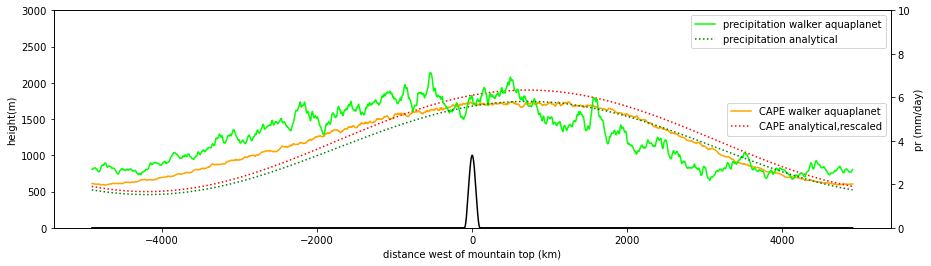

In [81]:
ax,ax2=plothrsection()
ax2.set_ylabel("pr (mm/day)")

ax2.plot(hrdist,hrchannel10_wk_aqua_precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='lime',label='precipitation walker aquaplanet')
ax2.plot((x-mcenter)/1000,pr_wk,'g:',label='precipitation analytical')


ax.plot(hrdist,hrchannel10_wk_aqua_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time']),color='orange',label='CAPE walker aquaplanet')
ax.plot((x-mcenter)/1000,20*CAPE_wk,'r:',label='CAPE analytical,rescaled')


ax.legend(loc="center right")
ax2.legend()
ax.set_ylim(0,3000)
ax2.set_ylim(0,10)
